### Import libraries

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from torch.utils.data import Dataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image

### DataClass

In [27]:
class CityScapes(Dataset):
    def __init__(self, root_dir, split='train',
                 custom_transform_image=None, custom_transform_label=None):
        super(CityScapes, self).__init__()
        # Save the root directory of the dataset
        self.root_dir = root_dir
        # Save the custom transformations
        self.custom_transform_image = custom_transform_image
        self.custom_transform_label = custom_transform_label
        # Define the transformations for the label
        self.transform_label = Compose([
            Resize((512, 1024)),
        ])
        # Define the transformations for the image
        self.transform_image = Compose([
            Resize((512, 1024)),
            ToTensor(),
            Normalize(
                mean=[0.2954, 0.3339, 0.2950], 
                std=[0.1822, 0.1852, 0.1807]
            )
        ])

        # Image and label directories
        self.image_dir = os.path.join(root_dir, 'images', split)
        self.label_dir = os.path.join(root_dir, 'gtFine', split)
        # Get the list of cities
        self.cities = sorted(os.listdir(self.image_dir))

    def __getitem__(self, idx):
        # Find the city and image index
        for city in self.cities:
            # Get the list of images in the city
            images = os.listdir(os.path.join(self.image_dir, city))
            # Check if the index is in the range of the city
            if idx < len(images):
                # If it is, break the loop
                break
            # Otherwise, subtract the number of images in the city from the index
            # This will move the index to the next city
            idx -= len(images)

        # Load the image and label
        # Check if there are custom transformations
        if self.custom_transform_image != None:
            # Load the image with the custom transformation
            image = self.custom_transform_image(Image.open(os.path.join(self.image_dir, city, images[idx])))
        else:
            # Load the image with the default transformation
            image = self.transform_image(Image.open(os.path.join(self.image_dir, city, images[idx])))

        # Load the single channel label
        label = self.transform_label(Image.open(os.path.join(self.label_dir, city, images[idx].replace('leftImg8bit', 'gtFine_labelTrainIds'))))
        # Transform the label to a tensor
        label = torch.tensor(np.array(label)).long()

        # Return the image and label
        return image, label

    def __len__(self):
        # Sum the number of images in each city
        # This is the total number of images in the dataset
        return sum(len(os.listdir(os.path.join(self.image_dir, city))) for city in self.cities)

### Testing CityScapes

**Note: The imshow warning is due to the normalization that is done on images!**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


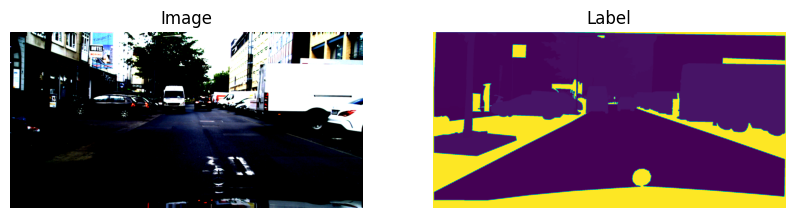

In [29]:
# Create the dataset
dataset = CityScapes(root_dir="Cityspaces", split='train')
# Get the first image and label
image, label = dataset[0]

# Plot the image and label
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(label)
plt.axis('off')
plt.title('Label')  
plt.show()

# Print unique values in the label
# print(f"Unique values in the label: {np.unique(label)}")